# ResNet20 on CIFAR-10

Based on https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_06_3_resnet.ipynb

*the model was trained in google colab with `batch=32` and no pixeal mean used*

In [1]:
%run '00_README.ipynb'

Imported helper functions from 00_README.ipynb
Imported all modules.
	Tensorflow Version:  2.2.0
	Numpy Version:  1.19.0
	Pandas Version:  1.0.5


GPU for training with Colab

In [2]:
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))

### Getting CIFAR-10 dataset

training data x shape: (50000, 32, 32, 3)
training data y shape: (50000, 1)
[7]


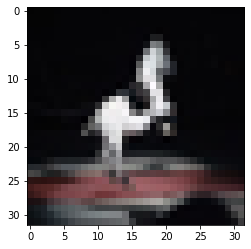

In [3]:
(x_train, y_train),(x_test, y_test) = tf.keras.datasets.cifar10.load_data()

print("training data x shape:", x_train.shape)
print("training data y shape:", y_train.shape)


plt.imshow(x_train[321].squeeze())
print(y_train[321])

#### Set input and output length globals for later (macros for mbed)

In [4]:
INPUT_LENGTH = x_test[1].flatten().shape[0]
OUTPUT_LENGTH = 10

### Exploring the data
#### Normalize dataset

In [5]:
x_train_normalized = x_train / 255
x_test_normalized = x_test / 255

print("training data shape:", x_train_normalized.shape)
print("test data shape:", x_test_normalized.shape)

training data shape: (50000, 32, 32, 3)
test data shape: (10000, 32, 32, 3)


In [6]:
import seaborn as sns
%matplotlib widget

sns.set(context='paper', style="ticks", color_codes=True, font='Times New Roman', font_scale=1, rc={"axes.grid": True })
sns.set_palette("muted")

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    #plt.style.use(['dark_background'])
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train_normalized[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i][0]], fontsize=16)
plt.show()


plt.savefig('CIFAR-10_examples.pdf')


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Create the model

In [7]:
# Training parameters
BATCH_SIZE = 32  # orig paper trained all networks with batch_size=128
EPOCHS = 1 # 200

USE_AUGMENTATION = False
# Subtracting pixel mean improves accuracy
SUBTRACT_PIXEL_MEAN = False

NUM_CLASSES = np.unique(y_train).shape[0] # 10
COLORS = x_train.shape[3]

# Computed depth from supplied model parameter n
DEPTH = COLORS * 6 + 2

In [8]:
print("training data y shape:", y_train.shape)

#y_train = tf.keras.utils.to_categorical(y_train, 10)
#y_test = tf.keras.utils.to_categorical(y_test, 10)

print("training data y shape with categories:", y_train.shape)

training data y shape: (50000, 1)
training data y shape with categories: (50000, 1)


In [9]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

The following code implements a ResNet block. This includes two convolutional layers with a skip connection. Both V1 and V2 of ResNet make use of this type of layer.

In [10]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = layers.Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=tf.keras.regularizers.l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = layers.BatchNormalization()(x)
        if activation is not None:
            x = layers.Activation(activation)(x)
    else:
        if batch_normalization:
            x = layers.BatchNormalization()(x)
        if activation is not None:
            x = layers.Activation(activation)(x)
        x = conv(x)
    return x

ResNet V1
- K. He, X. Zhang, S. Ren, and J. Sun. Deep residual learning for image recognition. arXiv preprint arXiv:1512.03385,2015.



In [11]:
def resnet_v1(input_shape, depth, num_classes=10, kernel_size=3):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature 
    map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of 
    filters is
    doubled. Within each stage, the layers have the same number 
    filters and the same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = layers.Input(shape=input_shape)
    x = resnet_layer(inputs=inputs, kernel_size=kernel_size)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            # first layer but not first stack
            if stack > 0 and res_block == 0:  
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides, kernel_size=kernel_size)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None, kernel_size=kernel_size)
            # first layer but not first stack
            if stack > 0 and res_block == 0:  
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = tf.keras.layers.add([x, y])
            x = layers.Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = layers.AveragePooling2D(pool_size=8)(x)
    y = layers.Flatten()(x)
    outputs = layers.Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    return model

In [13]:
    x_train = x_train.astype('float32') / 255
    x_test = x_test.astype('float32') / 255
    
    y_train = tf.keras.utils.to_categorical(y_train, NUM_CLASSES)
    y_test = tf.keras.utils.to_categorical(y_test, NUM_CLASSES)


In [33]:
models = []

In [32]:
kernel_sizes = [1,2,3,4,5,6,7]

In [34]:
kernel_size = [1]

In [36]:
for kernel_size in kernel_sizes:
    # Input image dimensions.
    input_shape = x_train.shape[1:]

    # Normalize data.



    # If subtract pixel mean is enabled
    if SUBTRACT_PIXEL_MEAN:
        x_train_mean = np.mean(x_train, axis=0)
        x_train -= x_train_mean
        x_test -= x_train_mean

    print('x_train shape:', x_train.shape)
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')
    print('y_train shape:', y_train.shape)

    # Convert class vectors to binary class matrices.

    # Create the neural network
    
    #with tf.device('/device:GPU:0'):
    model = resnet_v1(input_shape=input_shape, depth=DEPTH, kernel_size=kernel_size)

    model.compile(loss='categorical_crossentropy',
                    optimizer=tf.keras.optimizers.Adam(lr=lr_schedule(0)),
                    metrics=['accuracy'])
    model.summary()
    


    # Prepare callbacks for model saving and for learning rate adjustment.
    lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

    lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(factor=np.sqrt(0.1),
                                   cooldown=0,
                                   patience=5,
                                   min_lr=0.5e-6)

    callbacks = [lr_reducer, lr_scheduler]

    # Run training
    # Run training, with or without data augmentation.
    if not USE_AUGMENTATION:
        print('Not using data augmentation.')
        model.fit(x_train, y_train,
                  batch_size=BATCH_SIZE,
                  epochs=EPOCHS,
                  validation_data=(x_test, y_test),
                  shuffle=True,
                  callbacks=callbacks)
    
        
        model.save(f'./keras-model/01db_ResNet20-CIFAR-10_K-{kernel_size}.h5')
        models.append(model)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 10)
Learning rate:  0.001
Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_147 (Conv2D)             (None, 32, 32, 16)   64          input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_133 (BatchN (None, 32, 32, 16)   64          conv2d_147[0][0]                 
__________________________________________________________________________________________________
activation_133 (Activation)     (None, 32, 32, 16)   0           batc

In [30]:
models

[3]

In [2]:
model_name = '01d_ResNet20_CIFAR-10'

In [31]:
        model.save(f'./keras-model/01da_ResNet20-CIFAR-10_K-{kernel_size}.h5')

### Load the model
*continue here if you want to load a pretrained model*

In [ ]:
tf_model_file = './keras-model/01d_ResNet20_CIFAR-10.h5'
tf_model = tf.keras.models.load_model(tf_model_file)
tf_model.summary()

### Evaluate against the test set

[Losses Documentation](https://keras.io/api/losses/)


We used the `categorical_crossentropy` loss for training.

In [14]:
score = tf_model.evaluate(x=x_test_normalized, y=y_test, verbose=0)

tf_model_loss = score[0]
tf_model_accuracy = score[1]

print('Test accuracy:\t', tf_model_accuracy)
print('Test loss:\t', tf_model_loss)

Test accuracy:	 0.9185000061988831
Test loss:	 0.4342728555202484


### Running a single inference

Picks a random image from testset and then runs local inference using the original Keras model.

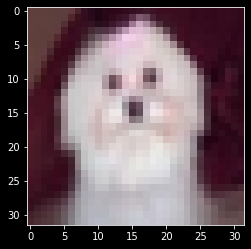

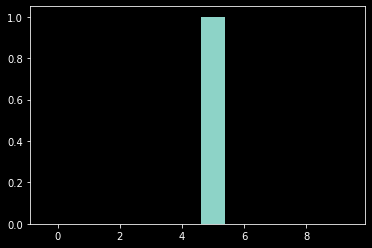

In [23]:

# pick a random image
image_no = np.random.randint(10000)

# use a single example image from the normalized training set
result = tf_model.predict(np.array( [ x_test_normalized[image_no] ] ))

plt.imshow(x_test_normalized[image_no].squeeze(), cmap=plt.cm.gray_r)
plt.show()
plt.figure()
plt.bar(np.arange(10), result[0])
plt.show()